In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd
from collections import defaultdict

colors_df = pd.read_parquet('/content/drive/MyDrive/google-photos/colors.parquet')
exif_df = pd.read_parquet('/content/drive/MyDrive/google-photos/exif.parquet')

In [6]:
import pandas as pd

df = pd.merge(colors_df, exif_df[['filename', 'date_taken']], on='filename', how='inner')
df['time_hhmm'] = df['date_taken'].str.extract(r'(\d{2}:\d{2}):\d{2}')[0]

df.head(1)

,filename,colors_hex_list,source_path,date_taken,time_hhmm
0,02d3e41a-c2f0-4bae-a778-de7d45ed2f3c.JPG,"#8c7a6d,#533f34,#33241c,#1d120c,#060503",/Volumes/Seagate Backup Plus Drive/backups/goo...,2023:05:21 00:36:53,23:05


Processing 29110 images...
After filtering: 29109 images with valid colors
Data parsed. Creating visualizations...


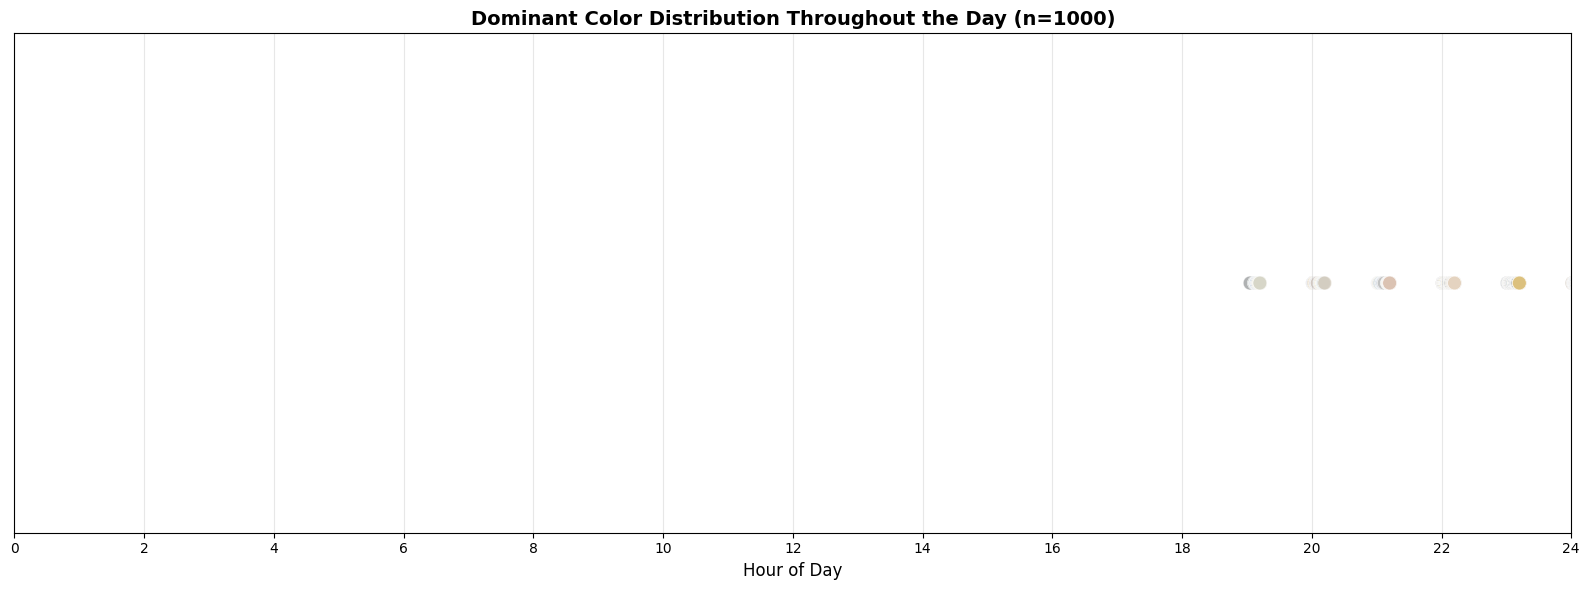

Visualization 1 complete.
Computing average colors by hour...


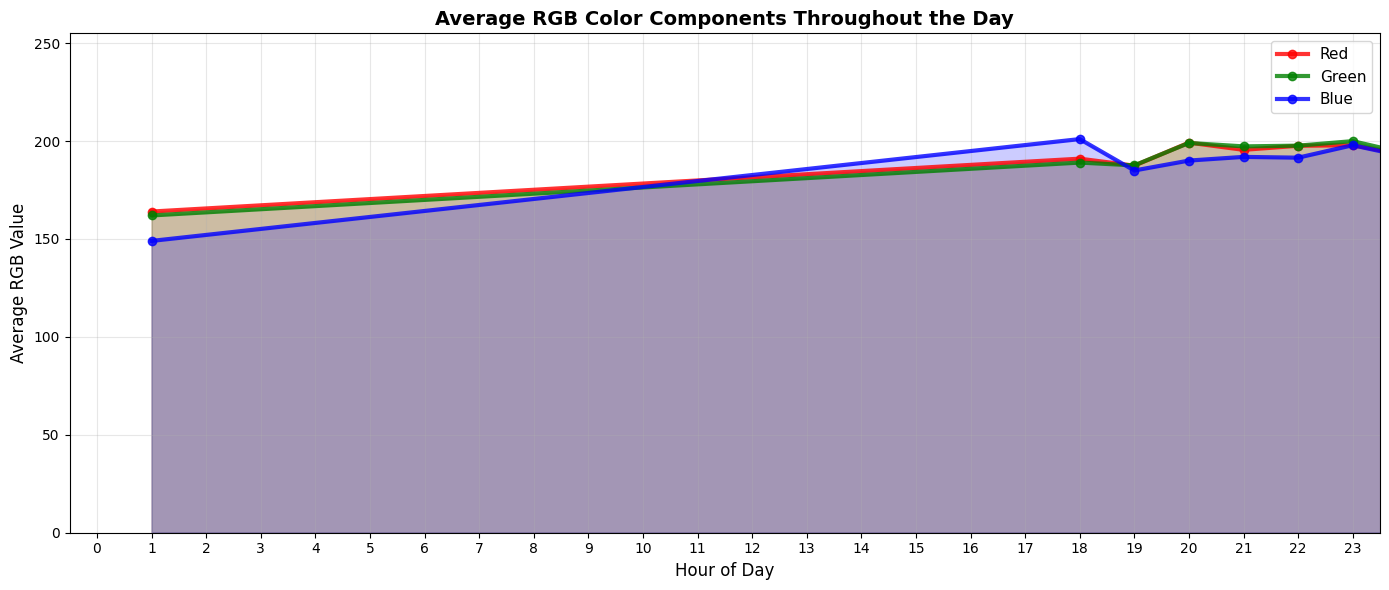

Visualization 2 complete.


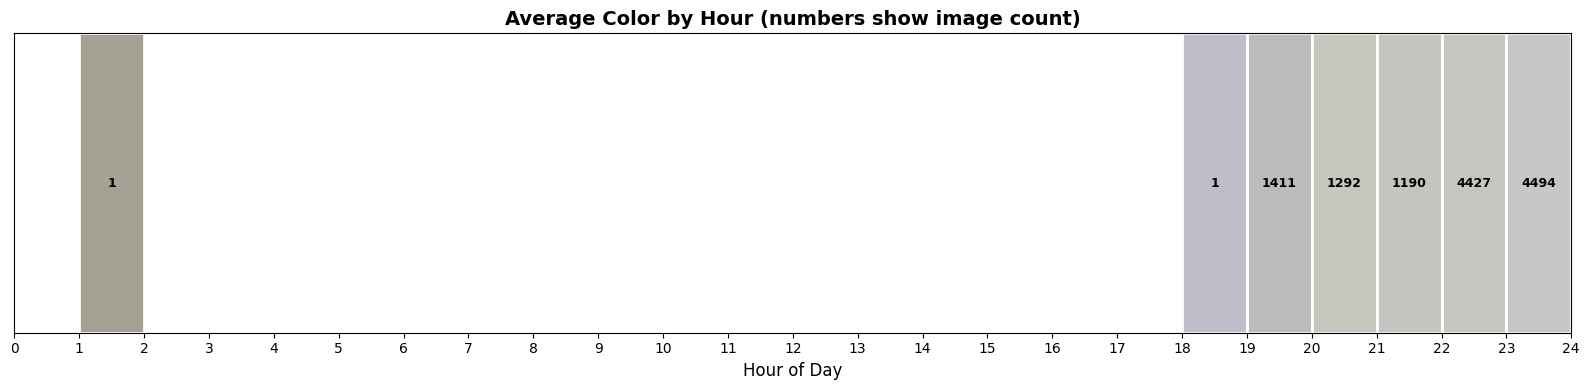

Visualization 3 complete.

=== Summary Statistics ===
Total images: 29109
Time range: 01:16 to 25:12
Average colors per image: 5.0

Images per hour:
hour
1        1
18       1
19    1411
20    1292
21    1190
22    4427
23    4494
24    7263
25    9030
dtype: int64

Most common hour: 25:00 (9030 images)
Least common hour: 1:00 (1 images)


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import hex2color
import numpy as np
from datetime import datetime

# Assuming your dataframe is named 'df'
# If you need to load it, uncomment and modify:
# df = pd.read_csv('your_file.csv')

print(f"Processing {len(df)} images...")

# Remove rows with missing time data
df = df.dropna(subset=['time_hhmm'])

# Parse the time from time_hhmm column (format: HH:MM)
df['hour'] = df['time_hhmm'].str.split(':').str[0].astype(int)
df['minute'] = df['time_hhmm'].str.split(':').str[1].astype(int)
df['time_decimal'] = df['hour'] + df['minute'] / 60

# Parse colors from hex list (do this once)
df['colors_list'] = df['colors_hex_list'].str.split(',')
df['dominant_color'] = df['colors_list'].str[0]

# Remove rows with missing colors
df = df.dropna(subset=['dominant_color'])
df = df[df['dominant_color'].str.len() > 0]

print(f"After filtering: {len(df)} images with valid colors")
print("Data parsed. Creating visualizations...")

# Visualization 1: Simplified scatter plot with dominant colors
fig, ax = plt.subplots(figsize=(16, 6))

# Sample data if too large (plot max 1000 points)
df_plot = df.sample(n=min(1000, len(df)), random_state=42).sort_values('time_decimal')

times = df_plot['time_decimal'].values
colors = df_plot['dominant_color'].values

# Create scatter plot with actual colors
ax.scatter(times, np.ones(len(times)), c=colors, s=100, alpha=0.7, edgecolors='white', linewidths=0.5)
ax.set_xlim(0, 24)
ax.set_ylim(0.5, 1.5)
ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_title(f'Dominant Color Distribution Throughout the Day (n={len(df_plot)})', fontsize=14, fontweight='bold')
ax.set_xticks(range(0, 25, 2))
ax.set_yticks([])
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("Visualization 1 complete.")

# Visualization 2: Average color by hour (much faster)
def hex_to_rgb(hex_color):
    """Convert hex to RGB tuple"""
    if hex_color is None or not hex_color:
        return (128, 128, 128)  # Default gray for invalid colors
    hex_color = hex_color.lstrip('#')
    try:
        return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    except:
        return (128, 128, 128)  # Default gray for invalid colors

# Vectorized RGB conversion for dominant colors
print("Computing average colors by hour...")
df['rgb'] = df['dominant_color'].apply(hex_to_rgb)
df['R'] = df['rgb'].apply(lambda x: x[0])
df['G'] = df['rgb'].apply(lambda x: x[1])
df['B'] = df['rgb'].apply(lambda x: x[2])

# Group by hour and get mean RGB
hourly_avg = df.groupby('hour')[['R', 'G', 'B']].mean()

fig, ax = plt.subplots(figsize=(14, 6))
hours = hourly_avg.index
ax.plot(hours, hourly_avg['R'], 'r-', label='Red', linewidth=3, alpha=0.8, marker='o')
ax.plot(hours, hourly_avg['G'], 'g-', label='Green', linewidth=3, alpha=0.8, marker='o')
ax.plot(hours, hourly_avg['B'], 'b-', label='Blue', linewidth=3, alpha=0.8, marker='o')
ax.fill_between(hours, hourly_avg['R'], alpha=0.2, color='red')
ax.fill_between(hours, hourly_avg['G'], alpha=0.2, color='green')
ax.fill_between(hours, hourly_avg['B'], alpha=0.2, color='blue')
ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Average RGB Value', fontsize=12)
ax.set_title('Average RGB Color Components Throughout the Day', fontsize=14, fontweight='bold')
ax.set_xlim(-0.5, 23.5)
ax.set_ylim(0, 255)
ax.set_xticks(range(0, 24))
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Visualization 2 complete.")

# Visualization 3: Color bar showing average color per hour
fig, ax = plt.subplots(figsize=(16, 4))

for hour in range(24):
    if hour in hourly_avg.index:
        r, g, b = hourly_avg.loc[hour, ['R', 'G', 'B']]
        # Normalize to 0-1 range for matplotlib
        color = (r/255, g/255, b/255)
        ax.add_patch(mpatches.Rectangle(
            (hour, 0),
            1,  # width
            1,  # height
            facecolor=color,
            edgecolor='white',
            linewidth=2
        ))
        # Add hour count
        count = len(df[df['hour'] == hour])
        ax.text(hour + 0.5, 0.5, f'{count}',
                ha='center', va='center', fontsize=9,
                color='white' if (r+g+b)/3 < 128 else 'black',
                fontweight='bold')

ax.set_xlim(0, 24)
ax.set_ylim(0, 1)
ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_title('Average Color by Hour (numbers show image count)', fontsize=14, fontweight='bold')
ax.set_xticks(range(0, 25))
ax.set_yticks([])
plt.tight_layout()
plt.show()

print("Visualization 3 complete.")

# Print summary statistics
print("\n=== Summary Statistics ===")
print(f"Total images: {len(df)}")
print(f"Time range: {df['time_hhmm'].min()} to {df['time_hhmm'].max()}")
print(f"Average colors per image: {df['colors_list'].apply(len).mean():.1f}")
print(f"\nImages per hour:")
print(df.groupby('hour').size().sort_index())
print(f"\nMost common hour: {df.groupby('hour').size().idxmax()}:00 ({df.groupby('hour').size().max()} images)")
print(f"Least common hour: {df.groupby('hour').size().idxmin()}:00 ({df.groupby('hour').size().min()} images)")